# "Стримчик". План на 2017 год

**Цели исследования:**

Проанализировать данные, найти возможные ошибки, составить портрети пользователей, проверить несколько гипотез, и выяснить, в каких регионах каким образом планировать продажи.

**Гипотезы:**

- Оценки пользователей игр Xbox One и PC значимо не отличаются.
- Оценки пользователей игр Action и Sports значимо отличаются.

**Ход исследования:**

Полученные данные необходимо проверить на качество - привести данные к необходимому типу, заполнить пропуски. После этого можно будет провести исследовательский анализ данных и проверить несколько статистических гипотез.

**Этапы:**

- [Получение данных](#getting)
- [Предобработка данных](#processing)
- [Исследование данных](#research)
- [Конструирование портретов пользователей](#users)
- [Проверка гипотез](#hypothesis)
- [Общий вывод](#resume)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

random_state = 42

<a id='getting'></a>
## Загрузка и подготовка данных


Считаем данные, приведём их в порядок, начнем исследование

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.columns = data.columns.str.lower()

<a id='processing'></a>
## Обработка данных

### Пропущенные значения

In [4]:
pd.DataFrame(round(data.isna().mean()*100,1).sort_values(ascending=False)).style.background_gradient('coolwarm')

,0
critic_score,51.300000
rating,40.500000
user_score,40.100000
year_of_release,1.600000
name,0.000000
platform,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000


В датасете довольно много пропущенных значений, связанных с рейтингами. Это могло произойти, потому что:
1. Игра может быть свежей, и не успеть набрать достаточно рейтинга
2. Игра может быть просто непопулярной

Пропущенных имен, годов выпуска и жанров совсем мало, от них лучше сразу избавиться. На рейтинши стоит посмотреть повнимательнее и подумать, как их заполнить.

In [5]:
data = data.dropna(subset=['name', 'genre', 'year_of_release'])
# после очистки данных года можно заменить его тип на целое число. Не бывает годов с дробной частью
data['year_of_release'] = data['year_of_release'].astype('int')
data.isna().sum() / data.shape[0] * 100

name                0.000000
platform            0.000000
year_of_release     0.000000
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.453418
user_score         40.166626
rating             40.598395
dtype: float64

Распределение похоже на нормальное, но с несколькими аномальными пиками.


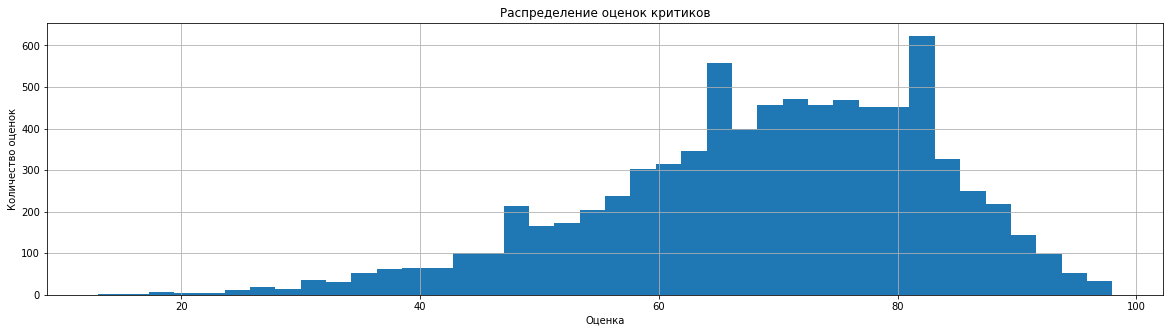

In [6]:
data['critic_score'].hist(figsize=(20, 5), bins=40)
plt.title('Распределение оценок критиков')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок');
print('''Распределение похоже на нормальное, но с несколькими аномальными пиками.''')

Оценки пользователей больше похожи на распределение Пуассона. Также много оценок tbd.
Рейтинг TBD (To Be Determined — «будет определено») — это способ оценки проектов или задач, 
которые еще не были выполнены, но вынуждены быть оценены.


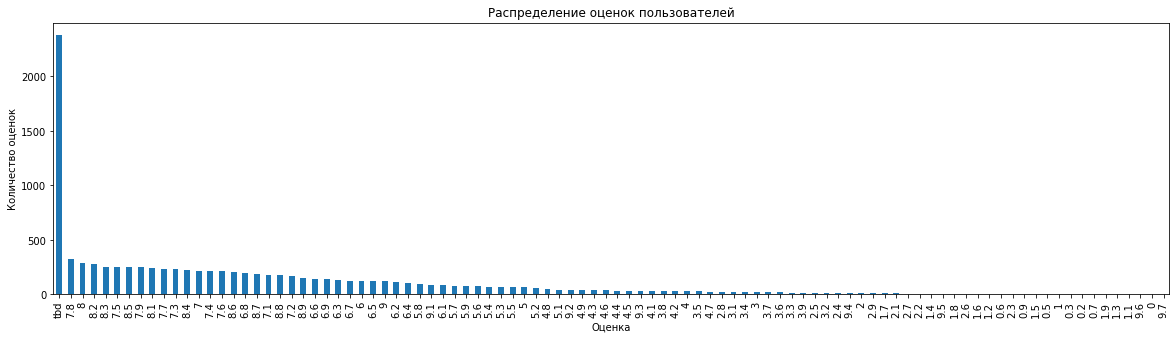

In [7]:
data['user_score'].value_counts().plot(kind='bar', figsize=(20, 5))
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.xticks(rotation=90);
print('''Оценки пользователей больше похожи на распределение Пуассона. Также много оценок tbd.
Рейтинг TBD (To Be Determined — «будет определено») — это способ оценки проектов или задач, 
которые еще не были выполнены, но вынуждены быть оценены.''')

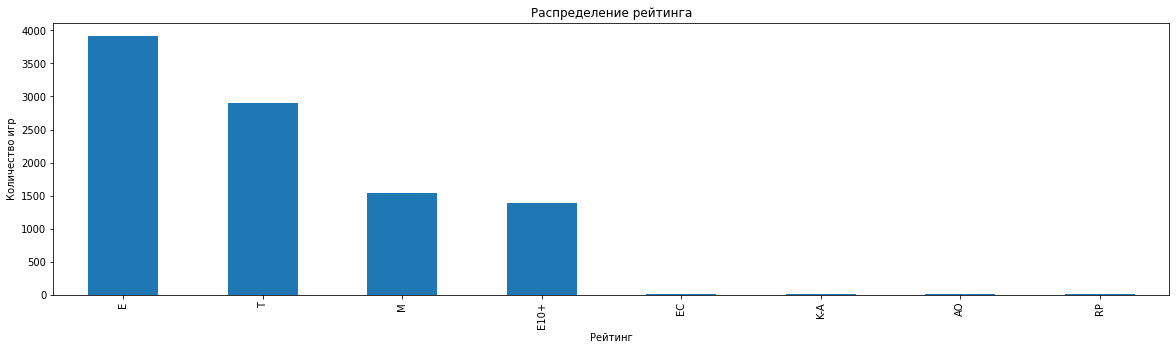

In [8]:
data['rating'].value_counts().plot(kind='bar', figsize=(20, 5))
plt.title('Распределение рейтинга')
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр');

Не проставленный рейтинг может нести определенную информацию о данных. Возможно, его ставят не на все типы игр. Вместо пропусков поставим заглушку "U" - unknown.

Оценки пользователей и критиков тоже можно заглушить нулями, чтобы они не влияли на расчеты

In [9]:
data['user_score'] = data['user_score'].fillna(0.0)
data.loc[data['user_score'] == 'tbd', 'user_score'] = 0.0

data['user_score'] = data['user_score'].astype('float')
data['critic_score'] = data['critic_score'].fillna(0)

data.loc[:, 'rating'] = data['rating'].fillna('U')

Появился один большой пик в нуле. Его можно будет отфильтровать при вычислениях. 
В любом случае, когда критик оценивает игру, он не ставит ноль баллов


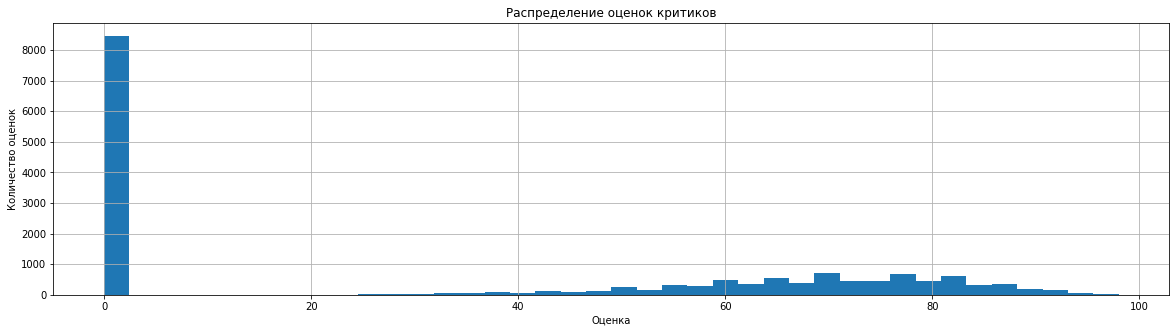

In [10]:
data['critic_score'].hist(figsize=(20, 5), bins=40)
plt.title('Распределение оценок критиков')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок');
print('''Появился один большой пик в нуле. Его можно будет отфильтровать при вычислениях. 
В любом случае, когда критик оценивает игру, он не ставит ноль баллов''')

Оценки пользователей тоже обзавелись пиком в нуле. 
Его тоже можно отфильтровать. Пользователи не ставят ноль при оценке


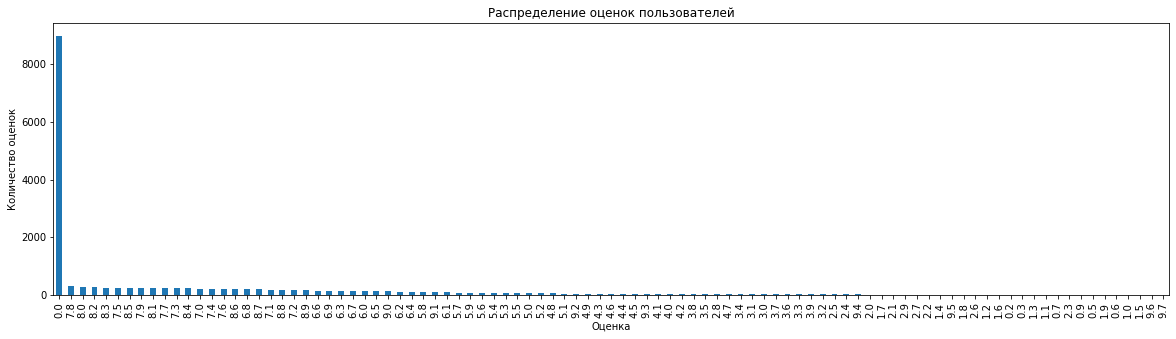

In [11]:
data['user_score'].value_counts().plot(kind='bar', figsize=(20, 5))
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.xticks(rotation=90);
print('''Оценки пользователей тоже обзавелись пиком в нуле. 
Его тоже можно отфильтровать. Пользователи не ставят ноль при оценке''')

In [12]:
# Посчитаем общие продажи игры во всех регионах
data['total_sales'] = data['na_sales'] + data['eu_sales'] +data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,U,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,U,31.38


### Дубли

In [13]:
data.duplicated().sum()
print('Явных дублей в датасете нет. Могут быть неявные')

Явных дублей в датасете нет. Могут быть неявные


In [14]:
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E,0.01


In [15]:
data[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3') & (data['year_of_release'] == 2012)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E,0.01


Нашелся один дубликат. Избавимся от него, а данные по продажам в Европе можно просто прибавить.

In [16]:
data = data.drop(16230)
data.loc[604, 'eu_sales'] += 0.01

In [17]:
data[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3') & (data['year_of_release'] == 2012)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E,2.56


**Вывод:**

В данных достаточно много пропусков. Нужно будет учесть это при дальнейшем исследовании и проверке гипотез. Также есть дубликат, от него удалось избавиться.

<a id='research'></a>
## Исследовательский анализ данных

### Выпуск игр в разные годы

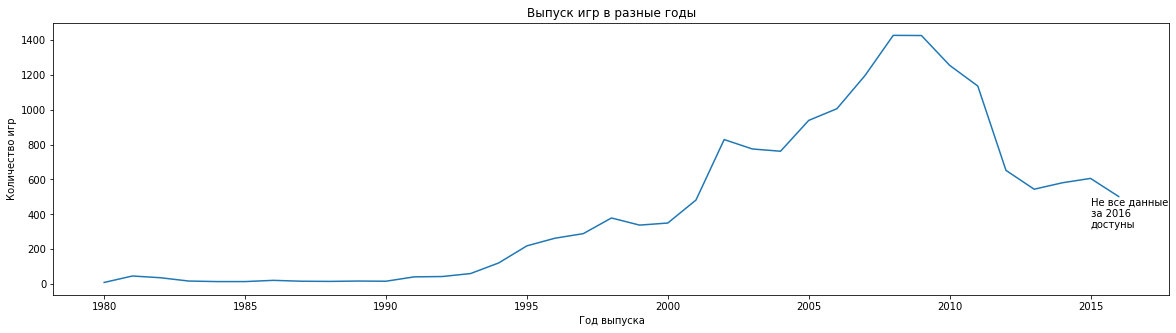

In [18]:
data.groupby('year_of_release')['name'].count().plot(figsize=(20,5))
plt.title('Выпуск игр в разные годы')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.annotate('Не все данные\nза 2016\nдостуны', (2015, 320));

На графике видно, что выпуск видеоигр сильно рос в период с 1995 по 2009 годы. После игр стало выходить гораздо меньше. Это может быть связано как с тем, что некоторые платформы стали уходить с рынка, так и с тем, что игры становились более технически сложными и на их выпуск стало требоваться больше времени.

### Изменение продаж по платформам

In [19]:
max_sales_platforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:7]
max_sales_platforms_by_year = (data[data['platform'].isin(max_sales_platforms)]
                               .pivot_table(index=['platform', 'year_of_release']
                                            ,values='total_sales'
                                            ,aggfunc='sum')
                               .reset_index())

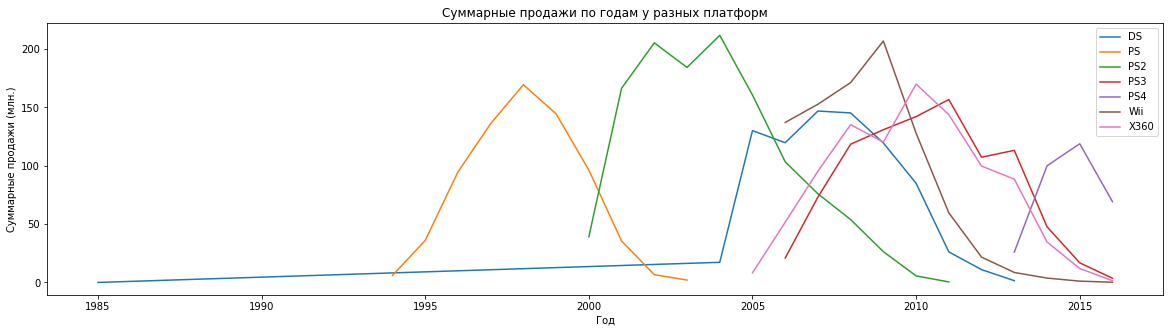

In [20]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(ax=ax,
             data=max_sales_platforms_by_year,
             x='year_of_release',
             y='total_sales',
             hue='platform')
plt.legend(loc='best')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи (млн.)')
plt.title('Суммарные продажи по годам у разных платформ')
plt.show()

Стоит обратить внимание на платформу DS. Там есть странная точка в 1985 году. Она станна тем, что платформа вышла в 2004 году. Посмотрим на неё повнимательнее.

In [21]:
data[(data['platform'] == 'DS') 
     &
     (data['year_of_release'] == 1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,0.0,0.0,U,0.02


Удивительно, но игра действительно была выпущена в 1985 году. Наверное, она была портирована на DS. Значение можно переписать. 

https://arcadetemple.com/strongest-tokyo-university-shogi-ds-sales-numbers/

In [22]:
data.loc[data['name'] == 'Strongest Tokyo University Shogi DS', 'year_of_release'] = 2004

In [23]:
max_sales_platforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:7]
max_sales_platforms_by_year = (data[data['platform'].isin(max_sales_platforms)]
                               .pivot_table(index=['platform', 'year_of_release']
                                            ,values='total_sales'
                                            ,aggfunc='sum')
                               .reset_index())

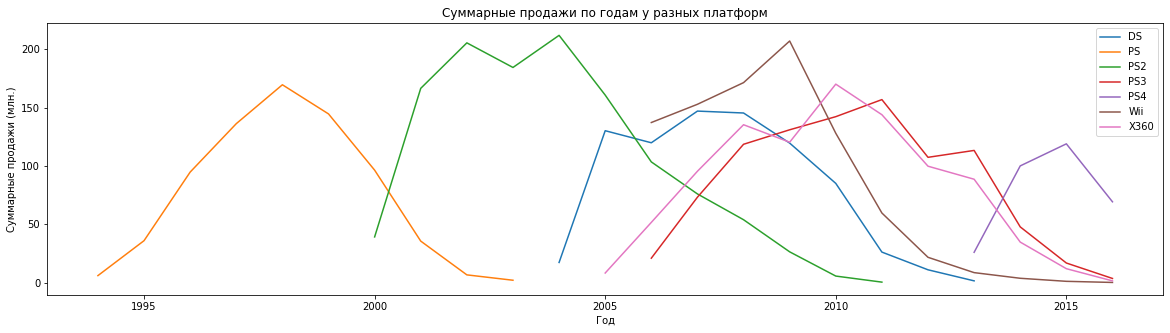

In [24]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(ax=ax,
             data=max_sales_platforms_by_year,
             x='year_of_release',
             y='total_sales',
             hue='platform')
plt.legend(loc='best')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи (млн.)')
plt.title('Суммарные продажи по годам у разных платформ')
plt.show()

In [25]:
# Определим средний жизненный цикл платформы
lifecycles = []
for platform in data['platform'].unique():
    if platform in ('PS4', 'XOne'):
        pass
    else:
        lifecycles.append(data[data['platform'] == platform]['year_of_release'].max() \
        - data[data['platform'] == platform]['year_of_release'].min())
import statistics

print(f'В среднем платформы живут {statistics.mean(lifecycles)} лет')

В среднем платформы живут 7 лет


Как долго будет жить платформа, зависит в первую очередь от самрй платформы. Можно увидеть, как платформы, вышедшие примерно в одно время, показывают разный жизненный цикл. Например, PS3 и X360 похожи друг на друга, вышли примерно в одно время и показали похожую динамику. При этом Wii, вышедшая даже чуть позже них, продемонстрировала гораздо более резкий пик и спад. 

Что касается платформы PS2, видно, как разко изменились продажи, когда вышла модель нового поколения - PS3, они стали падать менее интенсивно. Можно прежположить, что с выходом PS3 стоимость PS2 резко упала, и её начали покупать те, кто не был готов платить за неё полную стоимость.

Также видно, что чем дальше в будущее, тем более мощные устройства появляются на рынке и тем медленнее они устаревают. Жизненные циклы платформ становятся дольше.

В среднем платформы живут 7 лет.

### Лидеры продаж за актуальный период

In [26]:
# Актуальный период можно взять с 2015 года. Взяв период раньше, мы можем начать анализировать отжившие тренды
actual_data = data[data['year_of_release'] >= 2013]

In [27]:
actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
Name: total_sales, dtype: float64

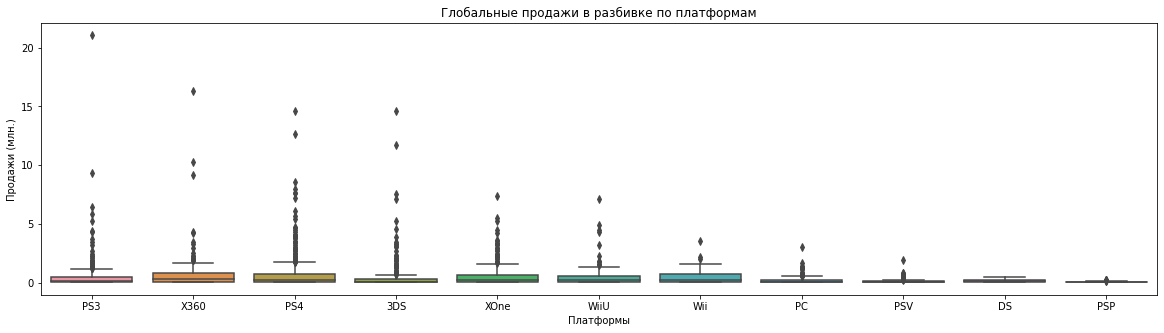

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(ax=ax,
            y='total_sales', 
            x='platform', 
            data=actual_data)
plt.title('Глобальные продажи в разбивке по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи (млн.)')
plt.show()

Видно, что в данных много выбросов. Прежде, чем продолжать анализ, следует избавиться от них.

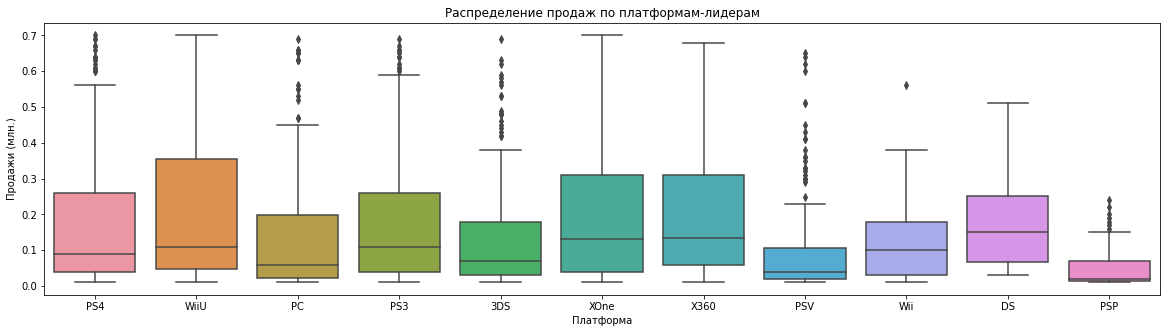

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(ax=ax,
            y='total_sales', 
            x='platform', 
            data=actual_data[actual_data['total_sales'] <= 0.7])
plt.title('Распределение продаж по платформам-лидерам')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн.)');

X360 и XOne лидируютпоказывает более высокую медиану. Это платформы одной компании, они - прямые конкуренты. Хотя XOne более новая платформа, X360 не спешит сдавать ей позиции. Также высокие продажи показывают PlayStation с платформами PS4 и PS3 и Nintendo с платформами Wii, WiiU и DS. PC держит неплохую позицию.    

### Влияние отзывов на продажи

Возьмём несколько популярных в актуальном периоде платформ и исследуем, как отзывы влияют на продажи.

In [30]:
data_critic = actual_data[(actual_data['critic_score'] > 0)]
actual_popular_platforms_c = data_critic.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:3]
actual_popular_data_c = data_critic[data_critic['platform'].isin(actual_popular_platforms_c)]

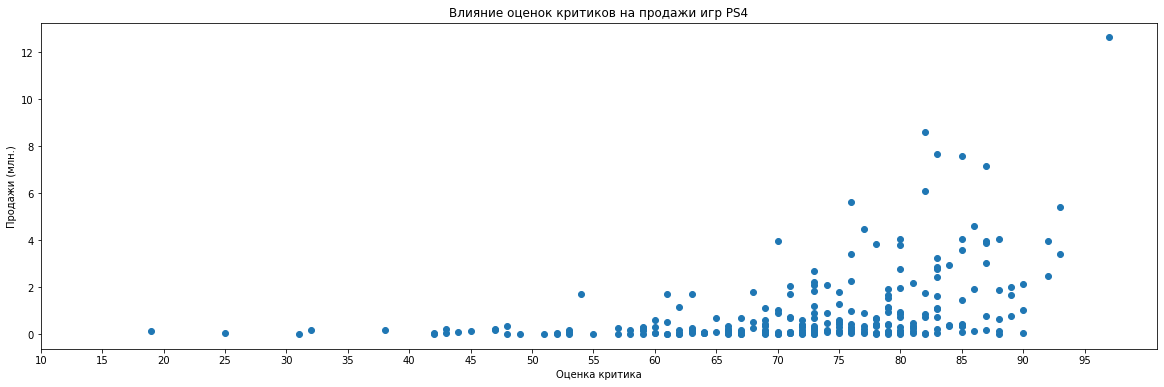

Коэффициент корреляции платформы PS4: 41.0 %


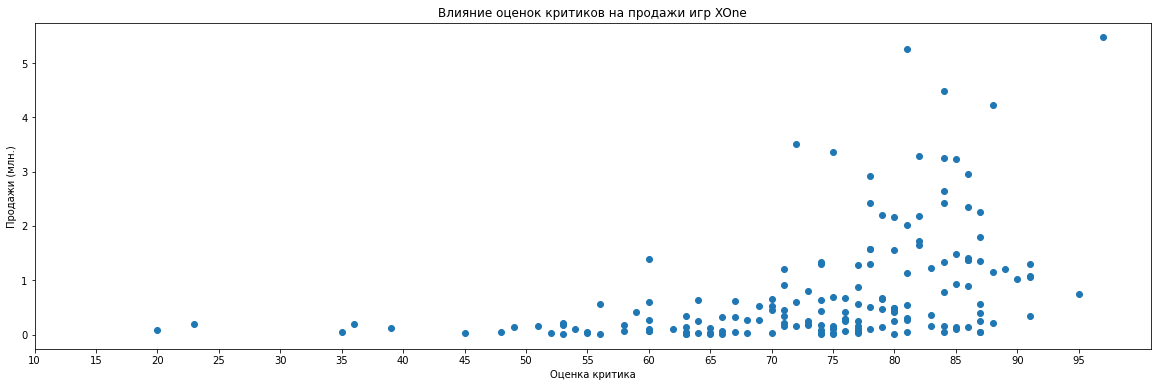

Коэффициент корреляции платформы XOne: 42.0 %


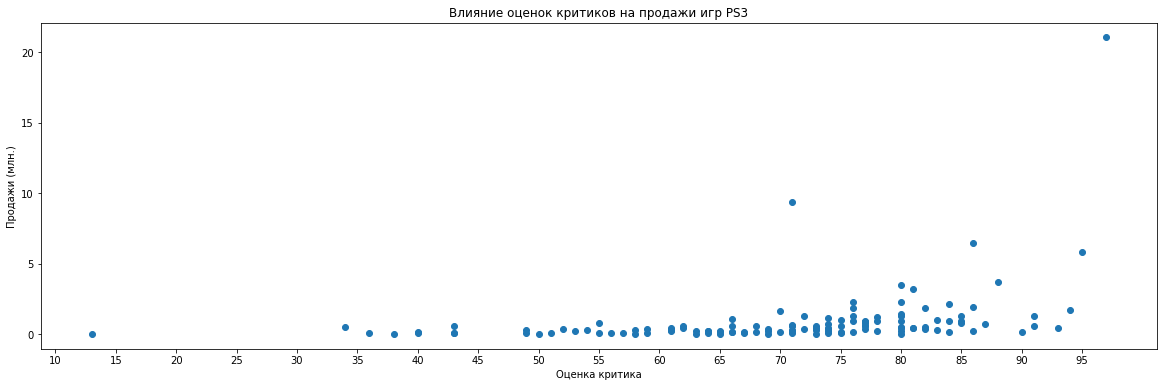

Коэффициент корреляции платформы PS3: 33.0 %


In [31]:
for platform in actual_popular_platforms_c:
    fig, ax = plt.subplots(figsize=(20,6))
    plt.scatter(x=actual_popular_data_c[actual_popular_data_c['platform'] == platform]['critic_score'], 
                y=actual_popular_data_c[actual_popular_data_c['platform'] == platform]['total_sales'])
    plt.xticks([x for x in range(10, 100, 5)])
    plt.title(f'Влияние оценок критиков на продажи игр {platform}')
    plt.xlabel('Оценка критика')
    plt.ylabel('Продажи (млн.)')
    plt.show();
    corr_critic = actual_popular_data_c[actual_popular_data_c['platform'] == platform][['critic_score', 'total_sales']].corr()
    print(f'''Коэффициент корреляции платформы {platform}: {corr_critic.iloc[0, 1].round(2) * 100} %''')

In [32]:
# Проведем аналогичное с оценкой пользователей

data_user = actual_data[(actual_data['user_score'] > 0)]
actual_popular_platforms_u = data_critic.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:3]
actual_popular_data_u = data_critic[data_critic['platform'].isin(actual_popular_platforms_u)]

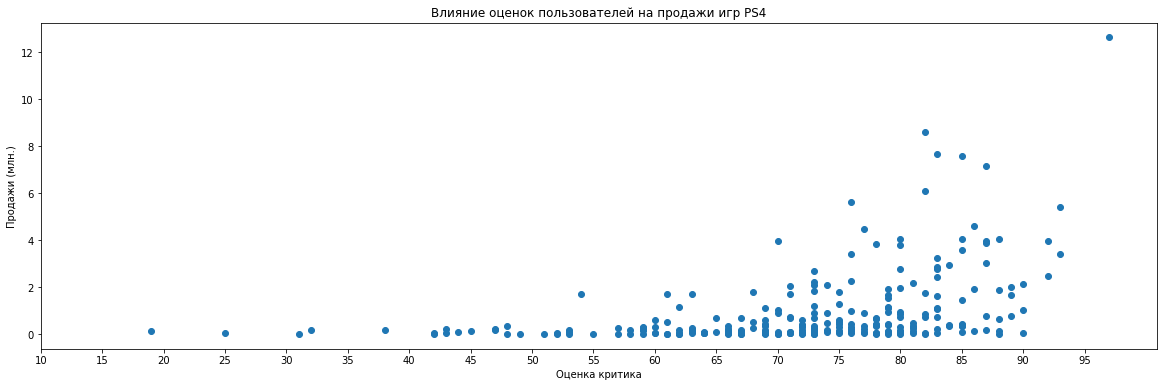

Коэффициент корреляции платформы PS4: -0.0 %


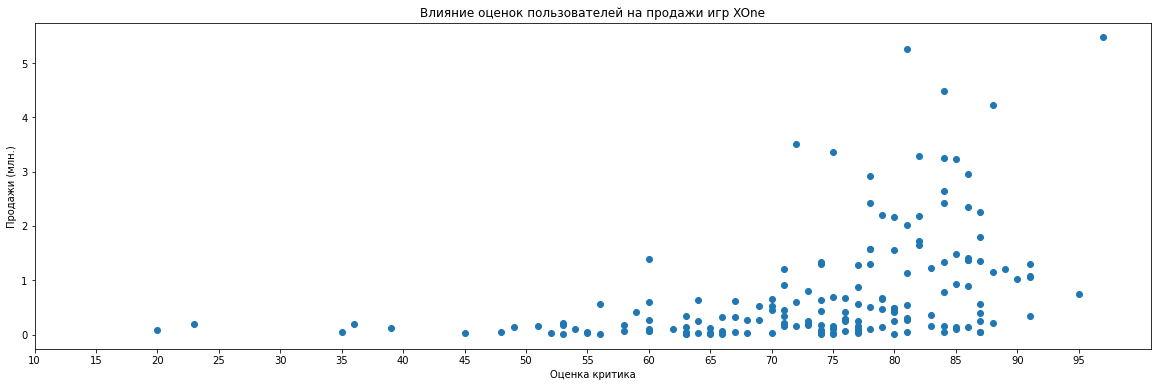

Коэффициент корреляции платформы XOne: -1.0 %


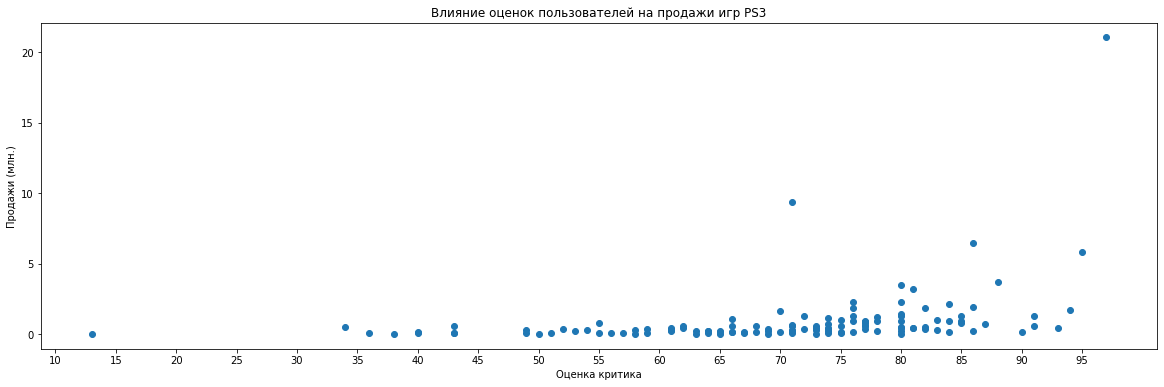

Коэффициент корреляции платформы PS3: 3.0 %


In [33]:
for platform in actual_popular_platforms_u:
    fig, ax = plt.subplots(figsize=(20,6))
    plt.scatter(x=actual_popular_data_u[actual_popular_data_u['platform'] == platform]['critic_score'], 
                y=actual_popular_data_u[actual_popular_data_u['platform'] == platform]['total_sales'])
    plt.xticks([x for x in range(10, 100, 5)])
    plt.title(f'Влияние оценок пользователей на продажи игр {platform}')
    plt.xlabel('Оценка критика')
    plt.ylabel('Продажи (млн.)')
    plt.show();
    corr_critic = actual_popular_data_u[actual_popular_data_u['platform'] == platform][['user_score', 'total_sales']].corr()
    print(f'''Коэффициент корреляции платформы {platform}: {corr_critic.iloc[0, 1].round(2) * 100} %''')

**Вывод об оценках**

В целом можно увидеть, что оценки критиков сильно влияют на продажи трех популярных платформ. Влияние оценок пользователей близко к нулю.

### Жанры

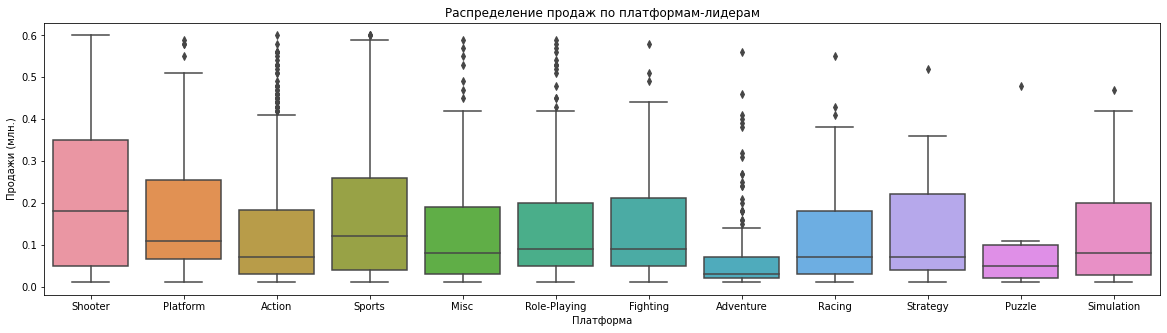

In [34]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(ax=ax,
            y='total_sales', 
            x='genre', 
            data=actual_data[actual_data['total_sales'] <= 0.6])
plt.title('Распределение продаж по платформам-лидерам')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн.)');

**Вывод о жанрах**

*Shooter, Racing и Sports* - более популярны. Возможно, потому что они во-первых, более простые и понятные, во-вторых, более динамичные.

*Strategy, Puzzle и Adventure* - в принципе выпускается мало игр всех трёх типов, а у *Strategy* ещё и порог входа очень высокий. Эти игры более медленные, они требуют большего умственного напряжения, а мозг не любит напрягаться.

<a id='users'></a>
## Портреты пользователей

### Платформы

In [35]:
leaders_na = actual_data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).index[:5]
leaders_eu = actual_data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).index[:5]
leaders_jp = actual_data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).index[:5]

print(f'''Популярные платформы в разных регионах:

Северная Америка: {leaders_na.values}
Европа:           {leaders_eu.values}
Япония:           {leaders_jp.values}''')

Популярные платформы в разных регионах:

Северная Америка: ['PS4' 'XOne' 'X360' 'PS3' '3DS']
Европа:           ['PS4' 'PS3' 'XOne' 'X360' '3DS']
Япония:           ['3DS' 'PS3' 'PSV' 'PS4' 'WiiU']


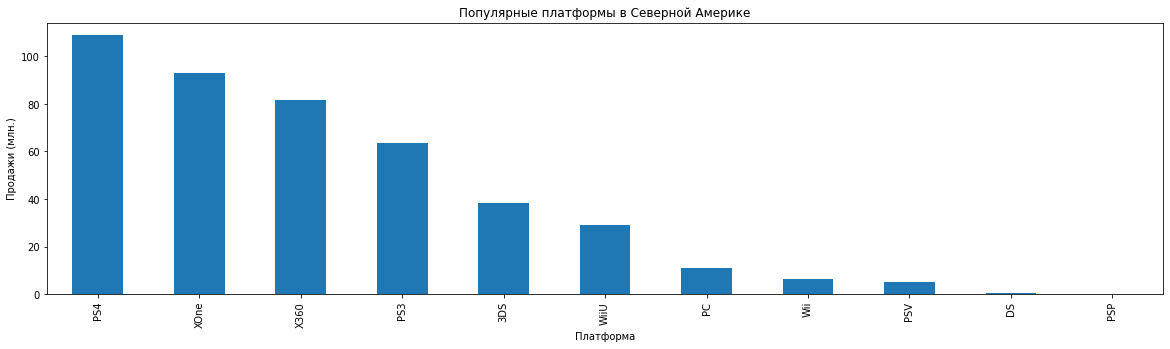

In [36]:
actual_data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Популярные платформы в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн.)');

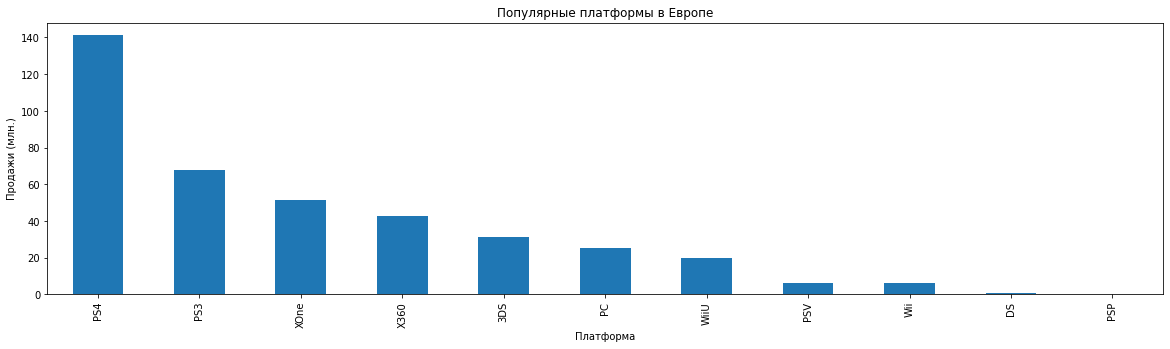

In [37]:
actual_data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Популярные платформы в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн.)');

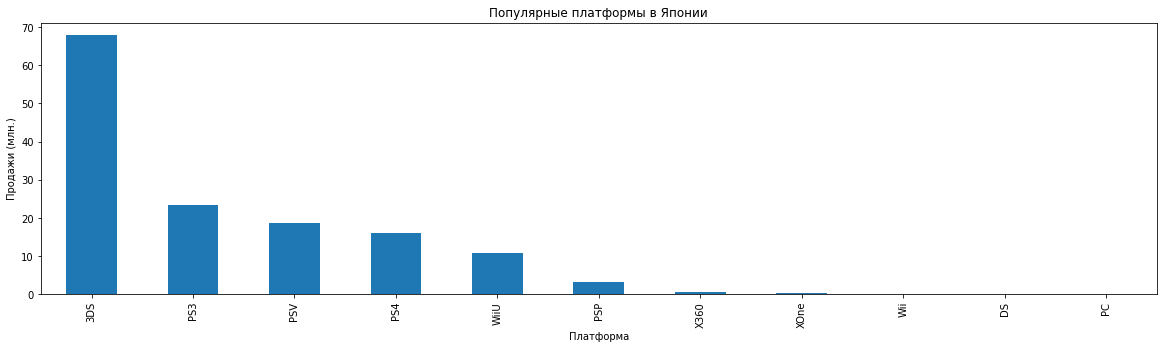

In [38]:
actual_data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Популярные платформы в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн.)');

В Америке и Европе лидируют - *PS4* и *XOne*. В целом топы западных стран очень похожи.

В Японии самая популярная платформа - *Nintento*. Весь остальной топ занимает PlayStation.

### Жанры

In [39]:
genres_na = actual_data.groupby('genre')['na_sales'].sum().sort_values(ascending=False).index[:5]
genres_eu = actual_data.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).index[:5]
genres_jp = actual_data.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).index[:5]

print(f'''Популярные жанры в разных регионах:

Северная Америка: {genres_na.values}
Европа:           {genres_eu.values}
Япония:           {genres_jp.values}''')

Популярные жанры в разных регионах:

Северная Америка: ['Action' 'Shooter' 'Sports' 'Role-Playing' 'Misc']
Европа:           ['Action' 'Shooter' 'Sports' 'Role-Playing' 'Racing']
Япония:           ['Role-Playing' 'Action' 'Misc' 'Fighting' 'Shooter']


Жанры в Америке и Европе почти идентичны поп популярности. В Японии уже довольно сильно отличаются. Скорее всего это связано с менталитетом и культурой. Европа и Америка в целом очень похожи друг на друга, Япония же несколько отличается. В целом все регионы любят Action, Shooter и RPG. Есть и незначительные местные отличия. В Европе больше любят Racing, в Японии Fighting и Misc. 

### Влияние ESRB на продажи

In [40]:
rating_na = actual_data.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
rating_eu = actual_data.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
rating_jp = actual_data.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

In [41]:
rating_na

rating
M       165.21
U        89.42
E        79.05
E10+     54.24
T        49.79
Name: na_sales, dtype: float64

In [42]:
rating_eu

rating
M       145.32
E        83.36
U        78.91
E10+     42.69
T        41.95
Name: eu_sales, dtype: float64

In [43]:
rating_jp

rating
U       85.05
T       20.59
E       15.14
M       14.11
E10+     5.89
Name: jp_sales, dtype: float64

Можно заметить, что в США и Европе более популярны игры *M* - для взрослых. Далее следуют игры *E* - для всех. В Японии не так много игр в принципе имеют рейтинг. Специфика рейтинга ESRB, такова, что он применяется главным образом для игр, реализуемых в США и Канаде. Отсюда и отсутствие рейтинга для игр в других регионах. Данных о Японии не так много, чтобы делать выводы о том, что рейтинги их игр сильно отличаются от западных.

<a id='hypothesis'></a>
## Проверка гипотез

### Одинаковы ли средние рейтинги пользователей Xbox One и PC?

<strong>Нулевая гипотеза:</strong> в среднем рейтинги пользователей Xbox One не отличаются от рейтингов пользователей PC<br>
<strong>Альтернативная гипотеза:</strong> в среднем рейтинги пользователей Xbox One отличаются от рейтингов пользователей PC

Чтобы проверить эту гипотезу, понадобится двустороннее сравнение средних двух выборок.

In [44]:
xone_user_score = actual_data[(actual_data['platform'] == 'XOne')
                              &
                              (actual_data['user_score'] > 0)]['user_score']
pc_user_score = actual_data[(actual_data['platform'] == 'PC')
                            &
                            (actual_data['user_score'] > 0)]['user_score']
results = st.ttest_ind(pc_user_score, 
                       xone_user_score, 
                       alternative='two-sided', 
                       equal_var=False)
alpha = 0.05 

print(f'''Средние оценки пользователей:
Xbox One: {xone_user_score.mean().round()}
PC: {pc_user_score.mean().round()}\n''')

print('p-значение:', results.pvalue, '\n')

if results.pvalue < alpha:
    print('''Отвергаем нулевую гипотезу. 
Средние оценки пользователей Xbox One отличаются от средних оценок пользователей PC.''')
else:
    print('''Не получилось отвергнуть нулевую гипотезу. 
Средние оценки пользователей Xbox One не отличаются от средних оценок пользователей PC.''') 

Средние оценки пользователей:
Xbox One: 7.0
PC: 6.0

p-значение: 0.14759594013430463 

Не получилось отвергнуть нулевую гипотезу. 
Средние оценки пользователей Xbox One не отличаются от средних оценок пользователей PC.


### Разные ли средние пользовательские рейтинги у жанров Action и Sports?

<strong>Нулевая гипотеза:</strong> в среднем пользовательские рейтинги жанра Action не отличаются от рейтингов жанра Sports<br>
<strong>Альтернативная гипотеза:</strong> в среднем пользовательские рейтинги жанра Action отличаются от рейтингов жанра Sports

Чтобы проверить эту гипотезу, также понадобится двустороннее сравнение средних двух выборок. Поскольку данных по *Action* сильно больше, возьмём оттуда рандомизированную выборку размера 389. Именно столько данных есть в выборке *Sports*

In [45]:
action_user_score = actual_data[(actual_data['genre'] == 'Action')
                                &
                                (actual_data['user_score'] > 0)]['user_score']
sports_user_score = actual_data[(actual_data['genre'] == 'Sports')
                                &
                                (actual_data['user_score'] > 0)]['user_score']

results = st.ttest_ind(sports_user_score, 
                       action_user_score, 
                       alternative='two-sided', 
                       equal_var=False)
alpha = 0.05 

print(f'''Средние оценки пользователей:
Action: {action_user_score.mean().round()}
Sports: {sports_user_score.mean().round()}\n''')

print('p-значение:', results.pvalue, '\n')

if results.pvalue < alpha:
    print('''Отвергаем нулевую гипотезу. 
Средние пользовательские оценки Action отличаются от средних оценок Sports.''')
else:
    print('''Не получилось отвергнуть нулевую гипотезу. 
Средние пользовательские оценки Action отличаются от средних оценок Sports.''') 

Средние оценки пользователей:
Action: 7.0
Sports: 5.0

p-значение: 1.4460039700704315e-20 

Отвергаем нулевую гипотезу. 
Средние пользовательские оценки Action отличаются от средних оценок Sports.


<a id='resume'></a>
## Общий вывод

**Что мы сделали:**
- Заполнили пропуски в данных;
- Удалили неявные дубликаты;
- Визуально оценили распределение данных в различных срезах;
- Составили портреты пользователей из разных стран;
- Проверили несколько гипотез;

**Выводы:**
- Чаще всего встречаются игры с рейтингом M, если рейтинг вообще заполнен, что происходит далеко не всегда;
- Период жизни игровой платформы около 7 лет;
- Самые популярные платформы: PlayStation, Xbox, Nintendo;
- Оценки критиков распределены вокруг 70 баллов. Это говорит о том, что выходящие игры в основном как минимум неплохие;
- Пользователи более тепло оценивают игры. Чаще встречаются оценки 7.0-8.0;
- Доверяют же пользователи больше оценкам критиков, чем оценкам других пользователей. Оценки критиков влияют на продажи, оценки пользователей - почти нет;
- В разных регионах популярны разные платформы и жанры. В Японии больше любят платформу Nintendo и жанры Action и RPG, в США и Европе - PlayStation, чаще играют в Shooter и Action;
- Несмотря на высокую популярность жанров Sports и Action, оценки этих жанров значимо отличаются;
- Что касается PC, то его оценки значимо не отличаются от оценок Xbox; 


**Рекомендации:**
- Общие:
-- Следить за оценками критиков в первую очередь и пользователей - во вторую. Закупать игры с высокими оценками;
-- Action, Shooter и RPG популярны во всех регионах. Их надо завозить в большом количестве;
-- PlayStation популярна во всех регионах. Игры для неё обязательно нужны везде;

- Америка и Европа
-- Очень похожи друг на друга. Помимо Action, Shooter и RPG они любят игры жанра Sports.
-- В Американских филиалах стоит представить чуть больше инди-игр, а в Европейских - гоночных.

- В Японии 
-- Доминирует Nintendo, нужно обеспечить игры этой платформы в первую очередь, а PlayStation уже во вторую;
-- Здесь популярны игры жанра Adventure;
-- Рейтинг в Японии мало что значит;